This is an attempt to use the example sk time in the other notebook for a forecasting project

### Libraries

In [123]:
import numpy as np
import pandas as pd
import statsmodels.api as sm # for example data

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster # for baseline model

%matplotlib inline
from sktime.utils.plotting import plot_series
import seaborn as sns
sns.set(rc={'figure.figsize':(20,16)})

from sktime.forecasting.base import ForecastingHorizon

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from sktime.forecasting.all import AutoARIMA, ExponentialSmoothing, AutoETS, Prophet

### Get data

In [108]:
# Pull data from stats models for example
df = sm.datasets.macrodata.load_pandas()['data']

# Making a single year/qtr field 
df['q_date'] = df.apply(lambda x: str(int(x['year'])) + '-Q' + str(int(x['quarter'])), axis=1)
# Specifying this as this is a time series and that the frequency is quarterly
df['date'] = pd.PeriodIndex(df['q_date'], freq='Q').to_timestamp()
# Using this as the index
df = df.set_index('date').to_period("Q")

# View df
df

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,q_date
date,,,,,,,,,,,,,,,
1959Q1,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00,1959-Q1
1959Q2,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74,1959-Q2
1959Q3,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09,1959-Q3
1959Q4,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06,1959-Q4
1960Q1,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19,1960-Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008Q3,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33,2008-Q3
2008Q4,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91,2008-Q4
2009Q1,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71,2009-Q1


### EDA

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 203 entries, 1959Q1 to 2009Q3
Freq: Q-DEC
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
 14  q_date    203 non-null    object 
dtypes: float64(14), object(1)
memory usage: 25.4+ KB


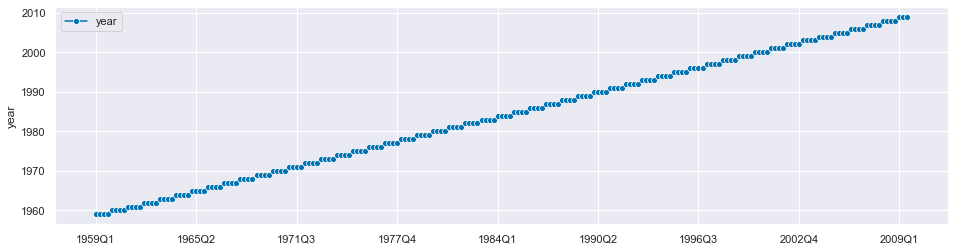

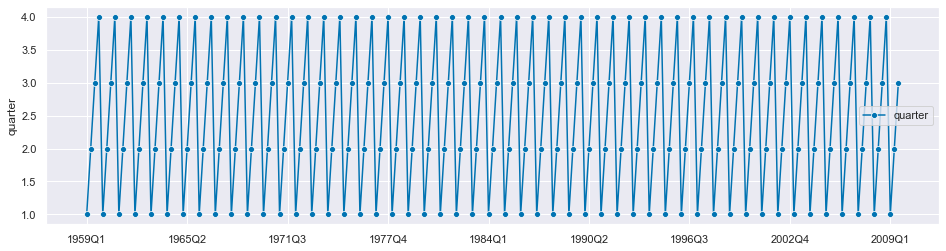

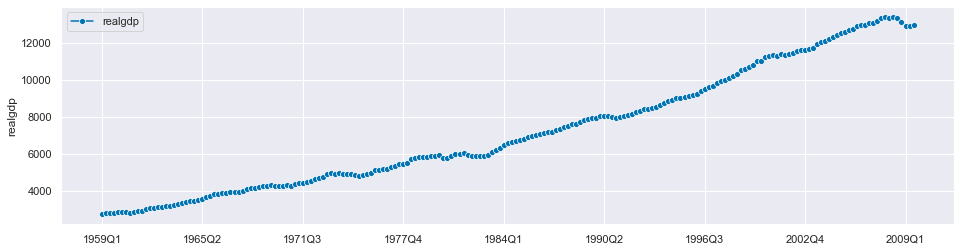

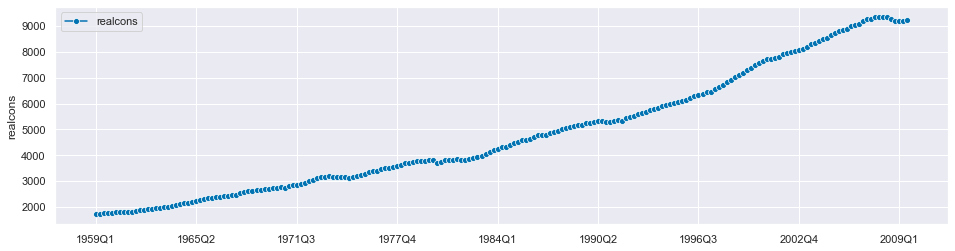

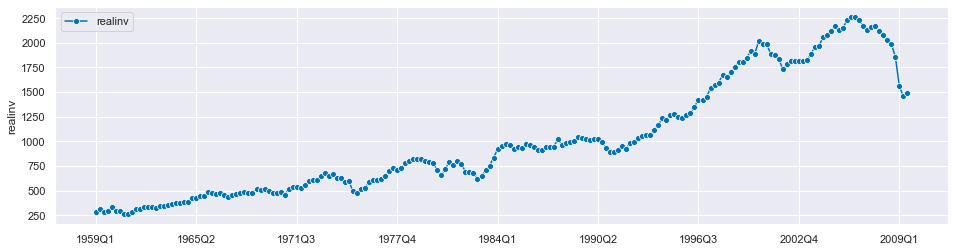

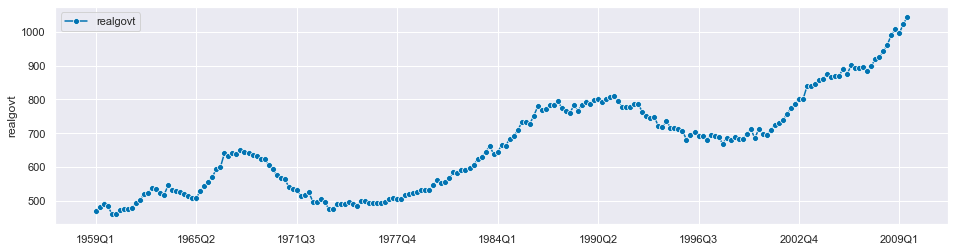

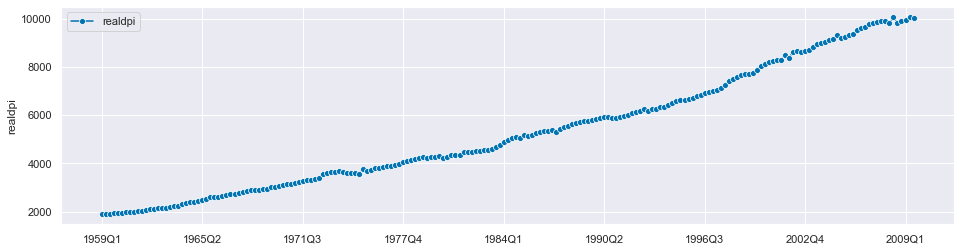

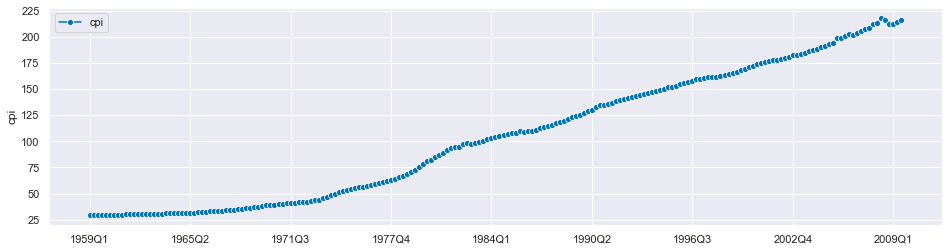

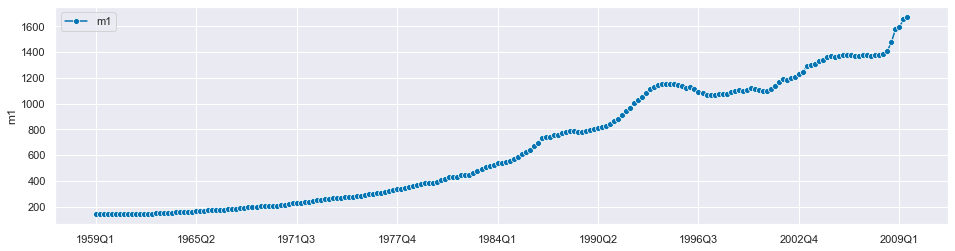

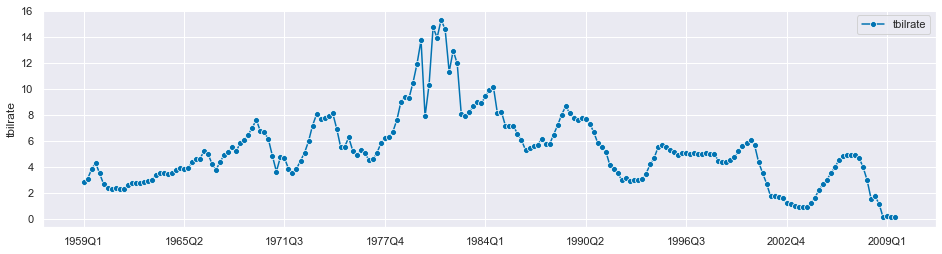

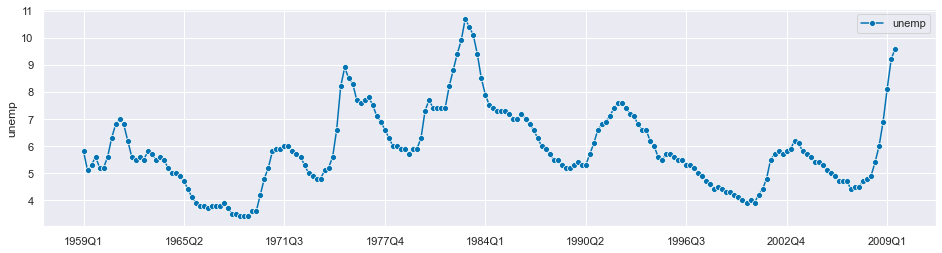

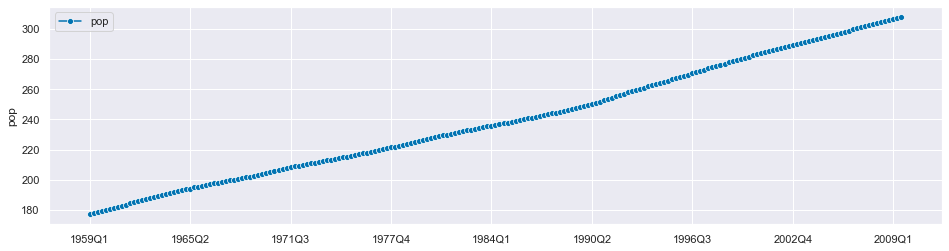

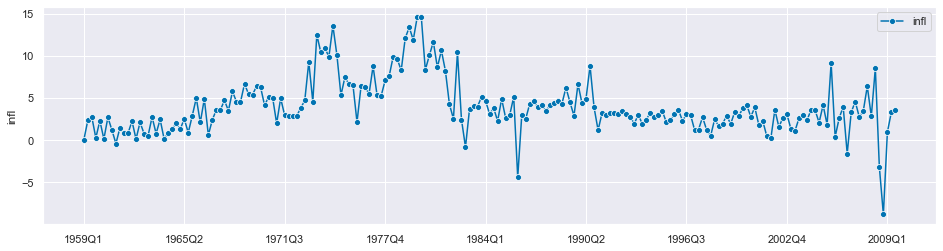

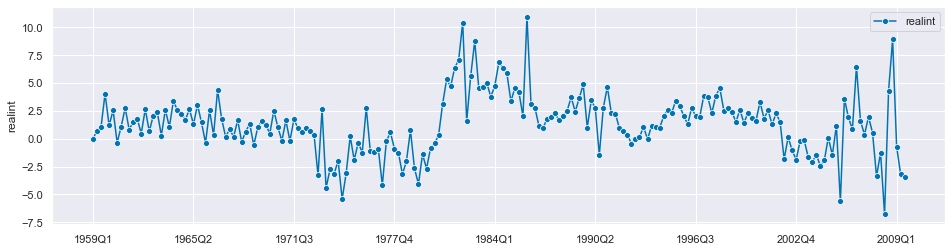

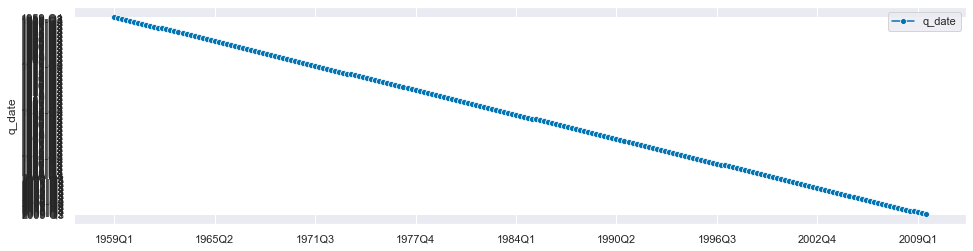

In [110]:
for i in list(df.columns):
    plot_series(df[i], labels=[f"{i}"])

#### Correlations

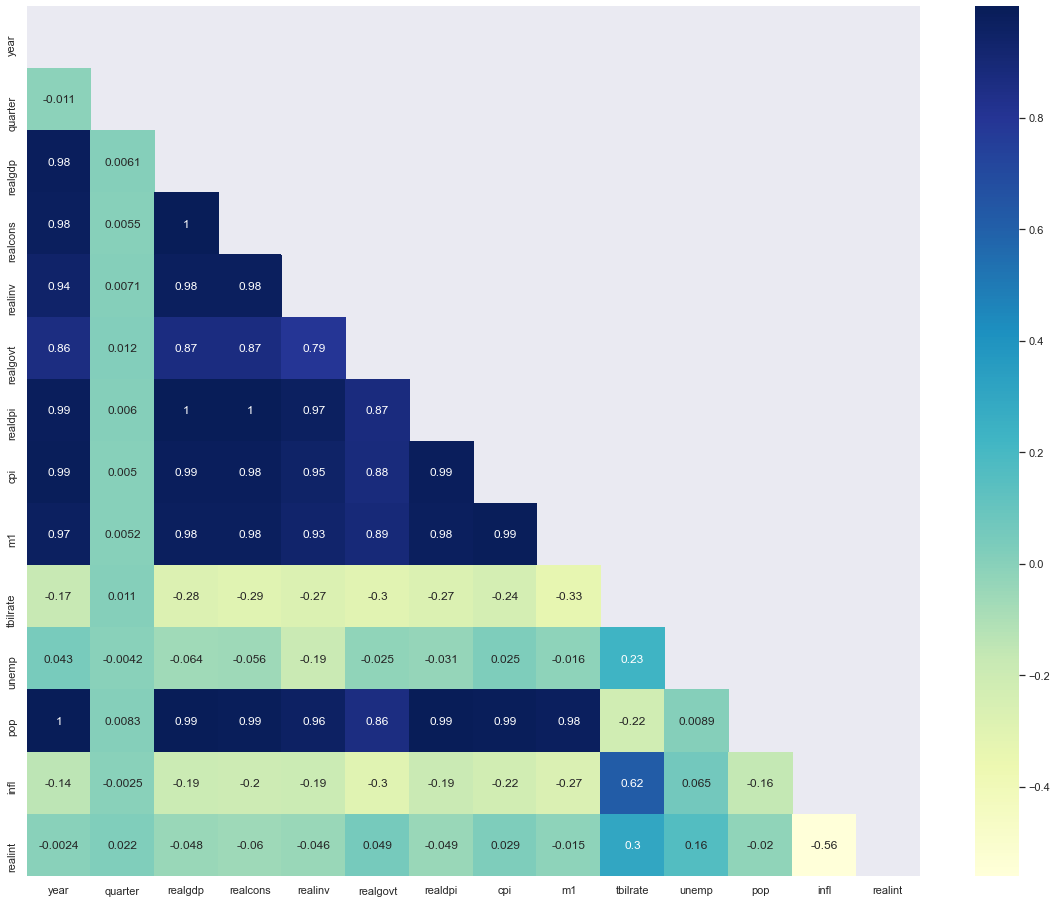

In [111]:
# creating mask
mask = np.triu(np.ones_like(df.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, mask=mask)

### Feature engineering

In [112]:
# Setting out features prior to lagging
features = list(df.columns)
drop_columns=['year', 'quarter', 'q_date']
for i in drop_columns:
    features.remove(i)

In [113]:
#creating lagged values for forecasting with exogenous variables
for i in features:
    df[f'{i}_lagged_1'] = df[i].shift(1).fillna(method='backfill')
    df[f'{i}_lagged_4'] = df[i].shift(4).fillna(method='backfill')
    df[f'{i}_lagged_12'] = df[i].shift(12).fillna(method='backfill')

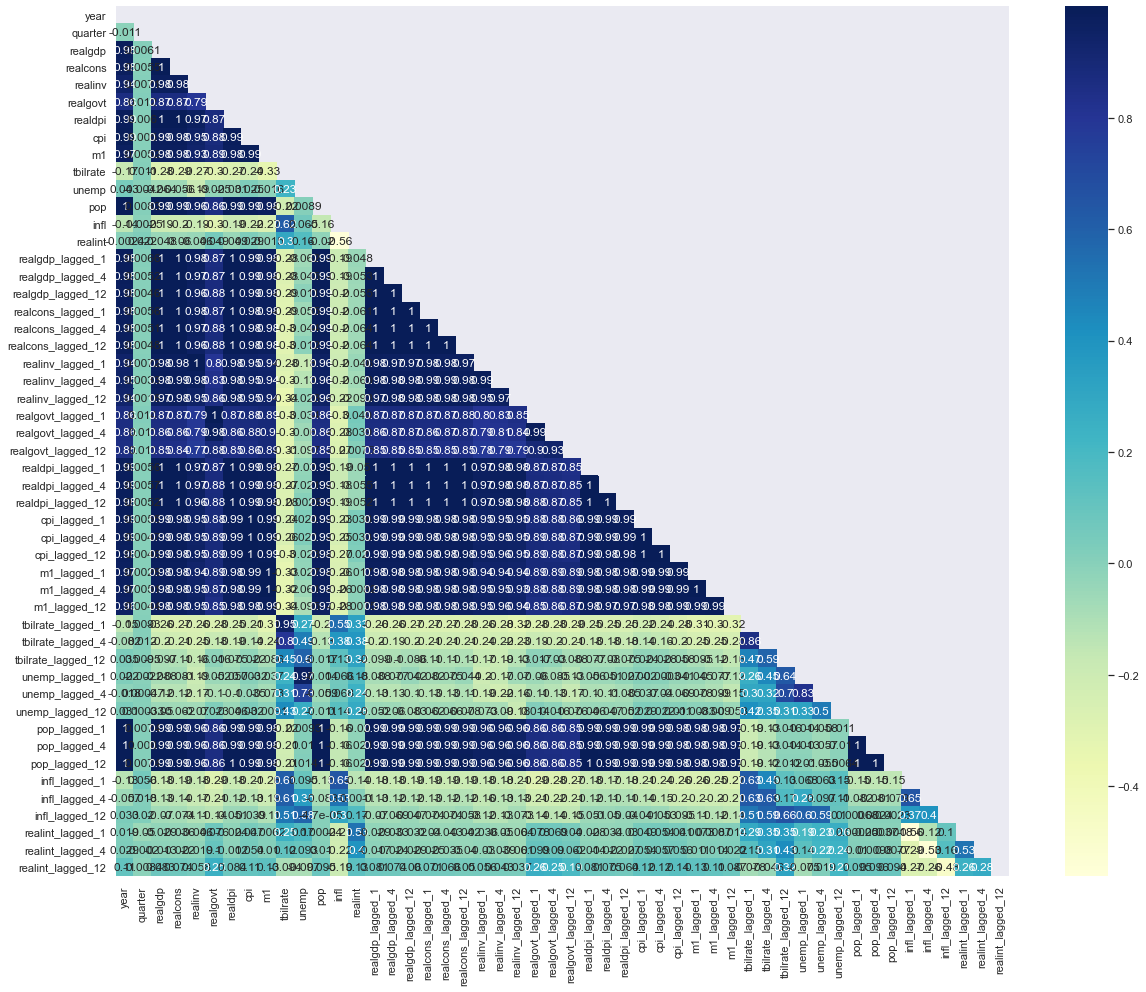

In [114]:
# creating mask (with lagged variables)
mask = np.triu(np.ones_like(df.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, mask=mask)

### Train / test split

The prediction target will be real gdp, I am going to use a 30% split for the test

In [115]:
y = df['realgdp']
X = df.drop(columns=['realgdp', 'realgdp_lagged_1', 'realgdp_lagged_4', 'realgdp_lagged_12']) 
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.2)
fh_abs = ForecastingHorizon(y_test.index, is_relative=False) 

# View input shapes
print('X Train shape: ', X_train.shape)
print('X Test shape: ', X_test.shape)
print('y Train shape: ', y_train.shape)
print('y Test shape: ', y_test.shape)

print(min(X_test.index))

X Train shape:  (162, 47)
X Test shape:  (41, 47)
y Train shape:  (162,)
y Test shape:  (41,)
1999Q3


In [116]:
#specific forecast horizon
fh_abs = ForecastingHorizon(y_test.index, is_relative=False)  
print(f"Absolute FH: {fh_abs}")

#last point in the training series
#cutoff = pd.Period("1999-09-01", freq="Q")
cutoff = min(X_test.index)
fh_rel = fh_abs.to_relative(cutoff)
print(f"\nRelative FH ahead: {list(fh_rel)}")

# quarters after the last point in the training series
cutoff_insample = pd.Period("2009-09-01", freq="Q")
fh_rel_insample = fh_abs.to_relative(cutoff_insample)
print(f"\nRelative FH in-sample: {list(fh_rel_insample)}")

Absolute FH: ForecastingHorizon(['1999Q3', '1999Q4', '2000Q1', '2000Q2', '2000Q3', '2000Q4',
             '2001Q1', '2001Q2', '2001Q3', '2001Q4', '2002Q1', '2002Q2',
             '2002Q3', '2002Q4', '2003Q1', '2003Q2', '2003Q3', '2003Q4',
             '2004Q1', '2004Q2', '2004Q3', '2004Q4', '2005Q1', '2005Q2',
             '2005Q3', '2005Q4', '2006Q1', '2006Q2', '2006Q3', '2006Q4',
             '2007Q1', '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2',
             '2008Q3', '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', freq='Q-DEC', is_relative=False)

Relative FH ahead: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

Relative FH in-sample: [-40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0]


### Baseline forecast

In [117]:
# Creating dictionary for performance metrics
perf_dict = dict()

Univariate naive forecast

           mae     mape           mse            r2          rmse
naive  0.14687  0.14687  3.106874e+06 -19011.388802  3.106874e+06


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='realgdp'>)

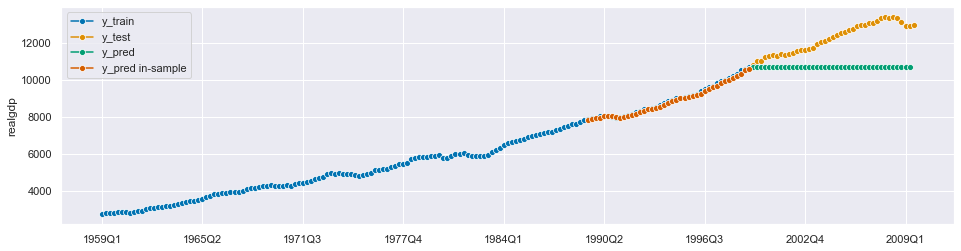

In [121]:
# Fit model
forecaster = NaiveForecaster().fit(y_train)
# Predict in and out of sample
y_pred_rel = forecaster.predict(fh=fh_rel)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)
# Add to performance dictionary
perf_dict['naive'] = {
    'mae': mean_absolute_percentage_error(y_pred_rel, y_test),
    'mse': mean_squared_error(y_pred_rel, y_test),
    'rmse': mean_squared_error(y_pred_rel, y_test, squared=True),
    'mape': mean_absolute_percentage_error(y_pred_rel, y_test),
    'r2': r2_score(y_pred_rel, y_test)
}

print(pd.DataFrame(perf_dict).T)

plot_series(y_train, y_test, y_pred_rel, y_pred_rel_insample, labels=["y_train", "y_test", "y_pred", "y_pred in-sample"])

### Traditional forecasting techniques

C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                mae           mse          rmse      mape            r2
naive      0.146870  3.106874e+06  3.106874e+06  0.146870 -19011.388802
autoARIMA  0.015009  6.167919e+04  6.167919e+04  0.015009      0.922032


C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\pmdarima\arima\arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\pmdarima\arima\arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='realgdp'>)

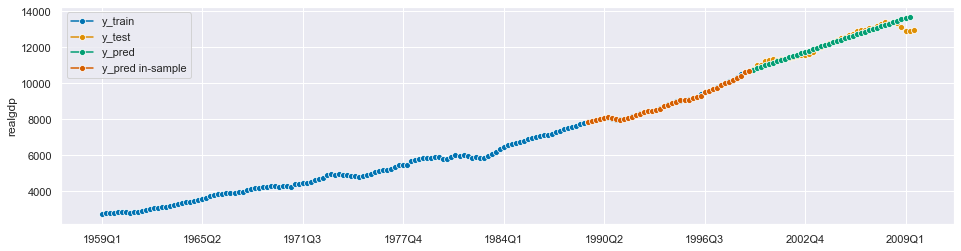

In [124]:
# Fit model
forecaster = AutoARIMA(sp=4)
forecaster.fit(y_train)
# Predict in and out of sample
y_pred_rel = forecaster.predict(fh=fh_rel)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)
# Add to performance dictionary
perf_dict['autoARIMA'] = {
    'mae': mean_absolute_percentage_error(y_pred_rel, y_test),
    'mse': mean_squared_error(y_pred_rel, y_test),
    'rmse': mean_squared_error(y_pred_rel, y_test, squared=True),
    'mape': mean_absolute_percentage_error(y_pred_rel, y_test),
    'r2': r2_score(y_pred_rel, y_test)
}

print(pd.DataFrame(perf_dict).T)

plot_series(y_train, y_test, y_pred_rel, y_pred_rel_insample, labels=["y_train", "y_test", "y_pred", "y_pred in-sample"])

                mae           mse          rmse      mape            r2
naive      0.146870  3.106874e+06  3.106874e+06  0.146870 -19011.388802
autoARIMA  0.015009  6.167919e+04  6.167919e+04  0.015009      0.922032
autoETS    0.146871  3.106900e+06  3.106900e+06  0.146871 -19011.055124


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='realgdp'>)

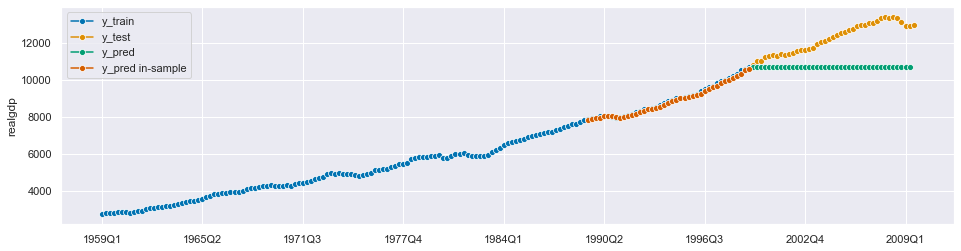

In [125]:
# Fit model
forecaster = AutoETS(sp=4)
forecaster.fit(y_train)
# Predict in and out of sample
y_pred_rel = forecaster.predict(fh=fh_rel)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)
# Add to performance dictionary
perf_dict['autoETS'] = {
    'mae': mean_absolute_percentage_error(y_pred_rel, y_test),
    'mse': mean_squared_error(y_pred_rel, y_test),
    'rmse': mean_squared_error(y_pred_rel, y_test, squared=True),
    'mape': mean_absolute_percentage_error(y_pred_rel, y_test),
    'r2': r2_score(y_pred_rel, y_test)
}

print(pd.DataFrame(perf_dict).T)

plot_series(y_train, y_test, y_pred_rel, y_pred_rel_insample, labels=["y_train", "y_test", "y_pred", "y_pred in-sample"])

                    mae           mse          rmse      mape            r2
naive          0.146870  3.106874e+06  3.106874e+06  0.146870 -19011.388802
autoARIMA      0.015009  6.167919e+04  6.167919e+04  0.015009      0.922032
autoETS        0.146871  3.106900e+06  3.106900e+06  0.146871 -19011.055124
exp smoothing  0.146870  3.106874e+06  3.106874e+06  0.146870 -19011.388752


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='realgdp'>)

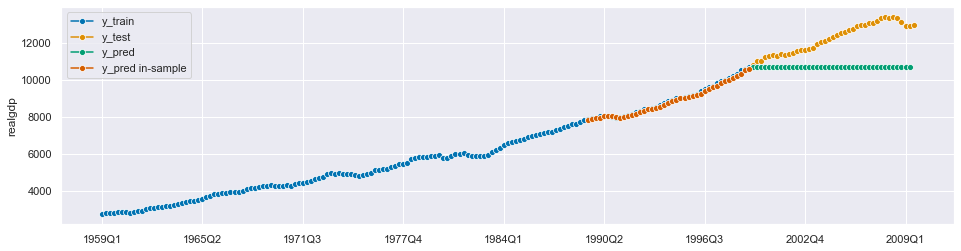

In [126]:
# Fit model
forecaster = ExponentialSmoothing(sp=4)
forecaster.fit(y_train)
# Predict in and out of sample
y_pred_rel = forecaster.predict(fh=fh_rel)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)
# Add to performance dictionary
perf_dict['exp smoothing'] = {
    'mae': mean_absolute_percentage_error(y_pred_rel, y_test),
    'mse': mean_squared_error(y_pred_rel, y_test),
    'rmse': mean_squared_error(y_pred_rel, y_test, squared=True),
    'mape': mean_absolute_percentage_error(y_pred_rel, y_test),
    'r2': r2_score(y_pred_rel, y_test)
}

print(pd.DataFrame(perf_dict).T)

plot_series(y_train, y_test, y_pred_rel, y_pred_rel_insample, labels=["y_train", "y_test", "y_pred", "y_pred in-sample"])

### Traditional techniques with multivariate features

In [130]:
X_test

,year,quarter,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,...,unemp_lagged_12,pop_lagged_1,pop_lagged_4,pop_lagged_12,infl_lagged_1,infl_lagged_4,infl_lagged_12,realint_lagged_1,realint_lagged_4,realint_lagged_12
1999Q3,1999.0,3.0,7286.4,1848.949,697.936,7765.9,168.100,1102.3,4.75,4.2,...,5.3,279.295,277.003,270.581,1.92,1.71,3.05,2.62,2.78,2.00
1999Q4,1999.0,4.0,7389.2,1914.567,713.445,7887.7,169.300,1121.9,5.20,4.1,...,5.3,280.203,277.790,271.360,3.35,1.95,3.02,1.41,2.43,1.97
2000Q1,2000.0,1.0,7501.3,1887.836,685.216,8053.4,170.900,1113.5,5.63,4.0,...,5.2,280.976,278.451,272.083,2.85,2.90,1.25,2.35,1.49,3.85
2000Q2,2000.0,2.0,7571.8,2018.529,712.641,8135.9,172.700,1103.0,5.81,3.9,...,5.0,281.653,279.295,272.912,3.76,1.92,1.25,1.87,2.62,3.76
2000Q3,2000.0,3.0,7645.9,1986.956,698.827,8222.3,173.900,1098.7,6.07,4.0,...,4.9,282.385,280.203,273.852,4.19,3.35,2.73,1.62,1.41,2.29
2000Q4,2000.0,4.0,7713.5,1987.845,695.597,8234.6,175.600,1097.7,5.70,3.9,...,4.7,283.190,280.976,274.626,2.77,2.85,1.24,3.30,2.35,3.88
2001Q1,2001.0,1.0,7744.3,1882.691,710.403,8296.5,176.400,1114.9,4.39,4.2,...,4.6,283.900,281.653,275.304,3.89,3.76,0.49,1.81,1.87,4.53
2001Q2,2001.0,2.0,7773.5,1876.650,725.623,8273.7,177.400,1139.7,3.54,4.4,...,4.4,284.550,282.385,276.115,1.82,4.19,2.46,2.57,1.62,2.52
2001Q3,2001.0,3.0,7807.7,1837.074,730.493,8484.5,177.600,1166.0,2.72,4.8,...,4.5,285.267,283.190,277.003,2.26,2.77,1.71,1.28,3.30,2.78
2001Q4,2001.0,4.0,7930.0,1731.189,739.318,8385.5,177.700,1190.9,1.74,5.5,...,4.4,286.047,283.900,277.790,0.45,3.89,1.95,2.27,1.81,2.43


In [129]:
# Fit model
forecaster = AutoARIMA(sp=4)
forecaster.fit(y_train, X_train)
# Predict in and out of sample
y_pred_rel = forecaster.predict(X=X_test, fh=fh_rel)
y_pred_rel_insample = forecaster.predict(X=X_test, fh=fh_rel_insample)
# Add to performance dictionary
perf_dict['autoARIMA MV'] = {
    'mae': mean_absolute_percentage_error(y_pred_rel, y_test),
    'mse': mean_squared_error(y_pred_rel, y_test),
    'rmse': mean_squared_error(y_pred_rel, y_test, squared=True),
    'mape': mean_absolute_percentage_error(y_pred_rel, y_test),
    'r2': r2_score(y_pred_rel, y_test)
}

print(pd.DataFrame(perf_dict).T)

plot_series(y_train, y_test, y_pred_rel, y_pred_rel_insample, labels=["y_train", "y_test", "y_pred", "y_pred in-sample"])

ValueError: could not convert string to float: '1959-Q1'